In [1]:
import numpy as np
import pandas as pd
import cobra
from cobra.io import read_sbml_model
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba
from IPython.display import display, Markdown

In [2]:
model = read_sbml_model('iCHO2441_221-107_producing.xml')
model

Set parameter Username
Set parameter LicenseID to value 2611274
Academic license - for non-commercial use only - expires 2026-01-17


Name,iCHO2441_221107_producing
Memory address,19d70769670
Number of metabolites,4174
Number of reactions,6337
Number of genes,2441
Number of groups,15
Objective expression,1.0*biomass_cho_prod - 1.0*biomass_cho_prod_reverse_1b5b7
Compartments,"cytosol, lysosome, mitochondria, endoplasmicReticulum, nucleus, extracellularSpace, peroxisome, golgiApparatus, secretoryVesicle"


In [3]:
#update bounds to match experimental late exponential data
bounds_df = pd.read_csv('bounds_df.csv')

for index, row in bounds_df.iterrows():
    reaction = model.reactions.get_by_id(row['reaction'])
    reaction.lower_bound = row['lower bound']
    reaction.upper_bound = row['upper bound']

In [4]:
#test all bounds updated correctly
mismatches = []
for index, row in bounds_df.iterrows():
    reaction = model.reactions.get_by_id(row['reaction'])
    if reaction.lower_bound != row['lower bound'] or reaction.upper_bound != row['upper bound']:
        mismatches.append((row['reaction'], reaction.lower_bound, reaction.upper_bound, row['lower bound'], row['upper bound']))

# Print mismatches if any
if mismatches:
    print(f"{len(mismatches)} reactions have incorrect bounds:")
    for rxn, lb_model, ub_model, lb_csv, ub_csv in mismatches[:10]:  # Show first 10 mismatches
        print(f"{rxn}: Model({lb_model}, {ub_model}) != CSV({lb_csv}, {ub_csv})")
else:
    print("All reaction bounds were correctly updated!")

All reaction bounds were correctly updated!


In [5]:
#remove non-negative bound on lactate and ammonia exchange reactions to match experimental findings

model.reactions.get_by_id('EX_lac_L(e)').lower_bound = -1000
model.reactions.get_by_id('EX_nh4(e)').lower_bound = -1000

In [16]:
def evaluate_objectives(df, model, criteria_reactions):
    """Returns a dict of how many of the feasible FVA combinations matched 0-4 of the qualitative criteria"""
    counts = {i: 0 for i in range(5)}
    
    for _, row in df.iterrows():
        with model:
            objective = model.problem.Objective(0, direction='max')
            for rxn_id, coeff in row.items():
                if coeff != 0:
                    model.reactions.get_by_id(rxn_id).objective_coefficient = coeff
            try:
                sol = loopless_solution(model)
            except:
                continue  # skip failed FBA runs

            matches = sum(
                condition(sol.fluxes[rxn]) if rxn in sol.fluxes else False
                for rxn, condition in criteria_reactions.items()
            )
            counts[matches] += 1
    return counts

In [20]:
#experimental qualitative criteria
criteria_reactions = {
    'EX_lac_L(e)': lambda f: f < 0,
    'EX_nh4(e)': lambda f: f < 0,
    'biomass_cho_prod': lambda f: f > 0,
    'igg_formation': lambda f: f > 0
}

#feasible FVA solutions
dfs = [
    pd.read_csv("ammonia_objectives_loopless.csv"),
    pd.read_csv("lactate_objectives_loopless.csv"),
    pd.read_csv("glucose_objectives_loopless.csv"),
    pd.read_csv("glutamine_objectives_loopless.csv")
]

# Accumulate counts across all feasible FVA solutions
total_counts = {i: 0 for i in range(5)}

for df in dfs:
    result = evaluate_objectives(df, model, criteria_reactions)
    for k in total_counts:
        total_counts[k] += result[k]


print(total_counts)

{0: 0, 1: 20, 2: 95, 3: 27, 4: 0}


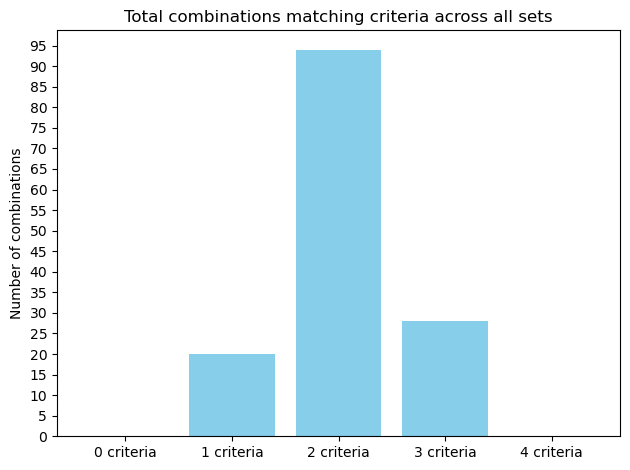

In [19]:
# Plot
plt.bar(total_counts.keys(), total_counts.values(), color='skyblue')
plt.xticks(range(5), [f"{i} criteria" for i in range(5)])
plt.ylabel("Number of combinations")
plt.title("Total combinations matching criteria across all sets")

# More ticks on y-axis
import numpy as np
y_max = max(total_counts.values())
plt.yticks(np.arange(0, y_max + 5, 5))  # tick every 5 units

plt.tight_layout()
plt.show()